# Deep Learning: Trying to replicate the model to generate better plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import time
import re
from matplotlib.axes._axes import Axes as matplotlib_Axis

import biotite.structure as struc
import biotite.structure.io.pdb as bt_pdb
from Bio.PDB import PDBParser
from Bio.PDB.Structure import Structure as BioPy_PDBStructure
from Bio.PDB.Model import Model as BioPy_PDBModel
from Bio.PDB.PDBExceptions import PDBConstructionException

parser = PDBParser(QUIET=True)

atom_vector_dict = {x:i for i, x in enumerate(["H", "C", "N", "O", "S"])}
residue_vector_dict = {x:i for i, x in enumerate(["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"])}

rescode_dict = {
    "ALA" : "A",
    "ARG" : "R",
    "ASN" : "N",
    "ASP" : "D",
    "CYS" : "C",
    "GLN" : "Q",
    "GLU" : "E",
    "GLY" : "G",
    "HIS" : "H",
    "ILE" : "I",
    "LEU" : "L",
    "LYS" : "K",
    "MET" : "M",
    "PHE" : "F",
    "PRO" : "P",
    "SER" : "S",
    "THR" : "T",
    "TRP" : "W",
    "TYR" : "Y",
    "VAL" : "V"
}

vector_size = 1 + len(residue_vector_dict)*2 + len(atom_vector_dict)*2
vector_offset_r1 = 1
vector_offset_r2 = vector_offset_r1 + len(residue_vector_dict)
vector_offset_a1 = vector_offset_r2 + len(residue_vector_dict) 
vector_offset_a2 = vector_offset_a1 + len(atom_vector_dict)
print(f"Vector size: {vector_size}; Atom 1 offset: {vector_offset_a1}")

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

Vector size: 51; Atom 1 offset: 41


In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc

In [3]:
# Settings

# Path to resource folder with the structures and metadata tables
path_resources = Path(r"D:\Eigene Datein\dev\Uni\JGU Bio Bachelorthesis\Daten\resources")

path_AF2 = path_resources / "AF2"
path_AF3 = path_resources / "AF3"
path_solved = path_resources / "solved"

In [4]:
dataAF2 = pd.read_csv(path_AF2 / "AF2_metrics.tsv", sep="\t")
# Old metrics
# dataAF2 = pd.read_csv(path_AF2 / "John metrics" / "AF_metrics_all_structures.tsv", sep="\t")
for c in ["chainA_start", "chainA_end", "chainB_start", "chainB_end", "num_mutations", "num_align_atoms_domain", "num_align_resi_domain", "hbonds", "salt_bridges", "hydrophobic_interactions"]:
    if c not in dataAF2.columns:
        print(f"Column {bcolors.FAIL}{c}{bcolors.ENDC} not (yet) in data frame")
        continue
    dataAF2[c] = dataAF2[c].astype(pd.Int64Dtype())
dataAF3 = pd.read_csv(path_AF3 / "AF3_metrics.tsv", sep="\t")
for c in ["chainA_start", "chainA_end", "chainB_start", "chainB_end", "num_mutations", "num_align_atoms_domain", "num_align_resi_domain", "hbonds", "salt_bridges", "hydrophobic_interactions"]:
    if c not in dataAF3.columns:
        print(f"Column {bcolors.FAIL}{c}{bcolors.ENDC} not (yet) in data frame")
        continue
    dataAF3[c] = dataAF3[c].astype(pd.Int64Dtype())

dataAF = pd.merge(
    left=dataAF3,
    right=dataAF2,
    left_on=["prediction_name", "model_id"],
    right_on=["prediction_name", "model_id"],
    suffixes=["_AF3", "_AF2"],
    how="inner"
)
for c in ["benchmark_set", "chainA_length", "chainB_length", "chainA_id", "chainB_id", "chainA_start", "chainA_end", "chainB_start", "chainB_end", "PDB_id", "ELM_instance", "DDI_pfam_id", "PDB_id_random_paired", "ELM_instance_random_paired", "DDI_pfam_id_random_paired", "sequence_initial", "sequence_mutated", "num_mutations"]:
    if len(dataAF[~(dataAF[c+"_AF2"] == dataAF[c+"_AF3"]) & (~dataAF[c+"_AF2"].isna()) & (~dataAF[c+"_AF3"].isna())]) > 0:
        print(f"Unmatched column {c}")
        continue
    dataAF.drop(columns=[c+"_AF2"], inplace=True)
    dataAF.rename(columns={c+"_AF3": c}, inplace=True)
dataAF["min_distance_AF2"] = dataAF["min_distance_AF2"].fillna(np.max(dataAF["min_distance_AF2"]))
dataAF["min_distance_AF3"] = dataAF["min_distance_AF3"].fillna(np.max(dataAF["min_distance_AF3"]))
display(dataAF)

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,RMSD_all_atom_AF2,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.976244,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.979658,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.969753,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,1.260424,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,1.759591,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,5.341712,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3166,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,5.975135,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3167,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,5.962444,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3168,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,5.901696,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>


In [5]:
from sklearn.metrics import pairwise_distances
from Bio.PDB.Atom import Atom as BioPy_Atom

class ProteinStructureWarning(Exception):
    def __init__(self, message):            
        super().__init__(message)

def get_distance_matrix(structure_biopy:BioPy_PDBStructure) -> tuple[np.ndarray, list[BioPy_Atom], list[BioPy_Atom]]:
    chains = [c for c in structure_biopy.get_chains()]
    if not len(chains) == 2: raise ProteinStructureWarning(f"The protein needs to have 2 chains but it has {len(chains)}")
    chain1 = structure_biopy[0][chains[0].id]
    chain2 = structure_biopy[0][chains[1].id]
    

    chain1_atoms = np.array([a for a in chain1.get_atoms()])
    chain2_atoms = np.array([a for a in chain2.get_atoms()])
    chain1_coords = [a.coord for a in chain1_atoms]
    chain2_coords = [a.coord for a in chain2_atoms]

    distance_matrix = pairwise_distances(chain1_coords,chain2_coords)

    return (distance_matrix, chain1_atoms, chain2_atoms)

def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff) # List of matrix indices where distance is below cutoff
    intf1_atoms = set(chain1_atoms[pair_dist[:, 0]]) # Set of the chain1 atoms with an atom from chain2 closer than cutoff distance
    intf2_atoms = set(chain2_atoms[pair_dist[:, 1]])

    # List of backbone atoms in the interface
    intf1_backbone = [a for a in intf1_atoms if a.name == "CA" and a in intf1_atoms]
    intf2_backbone = [a for a in intf2_atoms if a.name == "CA" and a in intf2_atoms]

    intf1_residues = [a.parent for a in intf1_backbone]
    intf2_residues = [a.parent for a in intf2_backbone]

    # A list for each chain combined to a tuple with the indices of the interface residues. Example : ([23, 445, 470], [26]) 
    backbone_indices_tuple = ([i for i,a in enumerate(chain1_atoms) if a in intf1_backbone], [i for i,a in enumerate(chain2_atoms) if a in intf2_backbone]) 

    # The distance matrix sliced to only the interface backbone atoms. So shape is (len(intf1_backbone), len(intf2_backbone))
    local_dist_matrix = distance_matrix[backbone_indices_tuple[0], :][:, backbone_indices_tuple[1]]

    min_distance = None
    if local_dist_matrix.size != 0:
        min_distance = round(np.min(local_dist_matrix), 3)

    return (intf1_residues, intf2_residues, min_distance)


In [151]:
intf.pairs[0].valid

In [152]:
class InterfacePair:

    def __init__(self, atom1: BioPy_Atom = None, atom2: BioPy_Atom = None, distance: float = None):
        self.atom1 = atom1
        self.atom2 = atom2
        self.valid: bool|None = None
        self.distance = float(distance)

    def __hash__(self):
        return hash(str(hash(self.atom1))+str(hash(self.atom2)))
    
    def __str__(self):
        a1_str = f"{self.atom1.element} in {self.atom1.parent.id[1]} {self.atom1.parent.resname} (chain {self.atom1.parent.parent.id})"
        a2_str = f"{self.atom2.element} in {self.atom2.parent.id[1]} {self.atom2.parent.resname} (chain {self.atom2.parent.parent.id})"
        valid_str = f" considered {'valid' if self.valid else 'invalid'}" if self.valid is not None else ""
        return f"<{a1_str}> <{a2_str}> @ {self.distance:1.3f} Å{valid_str}"
        return f"{int(self.valid) if self.valid is not None else ""}{str(self.atom1.parent.parent)}{str(self.atom1.parent)}{str(self.atom1)}, {str(self.atom2.parent.parent)}{str(self.atom2.parent)}{str(self.atom2)} @ {round(self.distance, 3)}"
    
    def __repr__(self):
        return self.__str__()

class Interface:

    def __init__(self, pairs: list[InterfacePair] = None):
        self.pairs: list[InterfacePair] = pairs if pairs is not None else []

    def get(self, mask:np.ndarray):
        return Interface(np.array(self.pairs)[mask])

    @property
    def distance(self):
        return np.array([x.distance for x in self.pairs])
    
    @property
    def residue1_id(self):
        return np.array([x.atom1.parent.id[1] for x in self.pairs])
    
    @property
    def residue2_id(self):
        return np.array([x.atom2.parent.id[1] for x in self.pairs])
    
    @property
    def element1(self):
        return np.array([x.atom1.element for x in self.pairs])
    
    @property
    def element2(self):
        return np.array([x.atom2.element for x in self.pairs])
    
    @property
    def valid(self):
        return np.array([x.valid for x in self.pairs])
    
    @valid.setter
    def valid(self, val: bool):
        for p in self.pairs: p.valid = val
    
    def __repr__(self):
        return "Interface:{\n" + '\n'.join(["\t" + str(p) for p in self.pairs]) + "\n}"
    
    def __str__(self):
        return f"<Interface of {len(self.pairs)} pairs>"
    
def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff)
    intf = Interface([InterfacePair(chain1_atoms[pair_dist[i,0]], chain2_atoms[pair_dist[i,1]], distance_matrix[pair_dist[i,0],pair_dist[i,1]]) for i in range(pair_dist.shape[0])])
    return intf

# Testing
structure_example_path = path_AF3 / "DMI" / "known_DMI" / "DEG_APCC_KENBOX_2_4GGD" / "ranked_0.pdb"
structure_example_biopy = parser.get_structure("structure", file=structure_example_path)

distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(structure_example_biopy)
intf = get_interface(distance_matrix, chain1_atoms, chain2_atoms)
intf

Interface:{
	<C in 19 ASN (chain A)> <O in 4 ASN (chain B)> @ 4.736 Å
	<O in 19 ASN (chain A)> <C in 4 ASN (chain B)> @ 4.444 Å
	<O in 19 ASN (chain A)> <N in 4 ASN (chain B)> @ 4.778 Å
	<O in 19 ASN (chain A)> <O in 4 ASN (chain B)> @ 4.176 Å
	<N in 20 ASP (chain A)> <O in 4 ASN (chain B)> @ 4.558 Å
	<C in 20 ASP (chain A)> <C in 4 ASN (chain B)> @ 4.150 Å
	<C in 20 ASP (chain A)> <N in 4 ASN (chain B)> @ 4.050 Å
	<C in 20 ASP (chain A)> <O in 4 ASN (chain B)> @ 3.658 Å
	<C in 20 ASP (chain A)> <C in 4 ASN (chain B)> @ 4.506 Å
	<C in 20 ASP (chain A)> <N in 4 ASN (chain B)> @ 4.496 Å
	<C in 20 ASP (chain A)> <O in 4 ASN (chain B)> @ 3.736 Å
	<O in 20 ASP (chain A)> <O in 4 ASN (chain B)> @ 4.926 Å
	<C in 20 ASP (chain A)> <C in 4 ASN (chain B)> @ 4.816 Å
	<C in 20 ASP (chain A)> <N in 4 ASN (chain B)> @ 4.286 Å
	<C in 20 ASP (chain A)> <O in 4 ASN (chain B)> @ 4.645 Å
	<C in 20 ASP (chain A)> <C in 4 ASN (chain B)> @ 4.373 Å
	<C in 20 ASP (chain A)> <N in 4 ASN (chain B)> @ 3.497 Å
	<

In [91]:
def interface_pair_to_vector(intfp: InterfacePair):
    vector1 = np.full(shape=(vector_size + 1,), fill_value=0, dtype="float")

    r1, r2 = intfp.atom1.parent.resname, intfp.atom2.parent.resname
    r1_class = residue_vector_dict[r1] if r1 in residue_vector_dict.keys() else -1
    r2_class = residue_vector_dict[r2] if r2 in residue_vector_dict.keys() else -1

    a1e, a2e = intfp.atom1.element, intfp.atom2.element
    a1_class = atom_vector_dict[a1e] if a1e in atom_vector_dict.keys() else -1
    a2_class = atom_vector_dict[a2e] if a2e in atom_vector_dict.keys() else -1

    if r1_class == -1 or r2_class == -2: return None
    if a1_class == -1 or a2_class == -2: return None

    vector1[0] = intfp.distance
    vector1[r1_class + vector_offset_r1] = 1
    vector1[r2_class + vector_offset_r2] = 1
    vector1[a1_class + vector_offset_a1] = 1
    vector1[a2_class + vector_offset_a2] = 1
    vector1[vector_size] = intfp.valid
    
    return vector1[0:vector_size+1]

In [7]:
dataAF["interface_AF3"] = None
dataAF_DMIs = dataAF[dataAF["benchmark_set"].str.contains("DMI")]
for i, row in dataAF_DMIs.iterrows():
    if i % 25 == 0:
        print(f"Processed {i}/{len(dataAF_DMIs)}")
    benchmark_set = row["benchmark_set"]
    set_ = "DMI" if "DMI" in benchmark_set else "DDI"
    pdb_id = row["PDB_id"]
    prediction_name = row["prediction_name"]
    model_id = row["model_id"]
    sequence, sequence_mutated = row["sequence_initial"], row["sequence_mutated"]

    path_struc = path_AF3 / set_ / benchmark_set / prediction_name / f"{model_id}.pdb"
    if not path_struc.exists():
        print(f"\t{prediction_name} does not have a valid AF3 prediction")
        continue
    biopy_struc = parser.get_structure("structure", file=path_struc)
    distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(biopy_struc)
    intf = get_interface(distance_matrix, chain1_atoms, chain2_atoms)

    if "known" in benchmark_set:
        intf.valid = True
    elif "random" in benchmark_set:
        intf.valid = False
    elif "mutations" in benchmark_set:
        intf.valid = True
        for n in range(len(sequence)):
            c1, c2 = sequence[n], sequence_mutated[n]
            if c1 == c2: continue
            intf.get(intf.residue2_id == (n+1)).valid = False
    else:
        print("Unexpected row")
        continue
    dataAF.at[i, "interface_AF3"] = intf

Processed 0/2700
Processed 25/2700
Processed 50/2700
Processed 75/2700
Processed 100/2700
Processed 125/2700
Processed 150/2700
Processed 175/2700
Processed 200/2700
Processed 225/2700
Processed 250/2700
Processed 275/2700
Processed 300/2700
Processed 325/2700
Processed 350/2700
Processed 375/2700
Processed 400/2700
Processed 425/2700
Processed 450/2700
Processed 475/2700
Processed 500/2700
Processed 525/2700
Processed 550/2700
Processed 575/2700
Processed 600/2700
Processed 625/2700
Processed 650/2700
Processed 675/2700
Processed 700/2700
Processed 725/2700
Processed 750/2700
Processed 775/2700
Processed 800/2700
Processed 825/2700
Processed 850/2700
Processed 875/2700
Processed 900/2700
Processed 925/2700
Processed 950/2700
Processed 975/2700
Processed 1000/2700
Processed 1025/2700
Processed 1050/2700
Processed 1075/2700
Processed 1100/2700
Processed 1125/2700
Processed 1150/2700
Processed 1175/2700
Processed 1200/2700
Processed 1225/2700
Processed 1250/2700
Processed 1275/2700
Proce

In [8]:
dataAF

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2,interface_AF3
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3,<Interface of 252 pairs>
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0,<Interface of 263 pairs>
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9,<Interface of 280 pairs>
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6,<Interface of 261 pairs>
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6,<Interface of 271 pairs>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>,None
3166,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>,None
3167,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>,None
3168,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>,None


## Creating datasets

In [94]:
pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.3, random_state=(seed := 2501))
rows_train = dataAF[(dataAF["benchmark_set"].isin(["known_DMI", "mutations_DMI"])) & (~dataAF["PDB_id"].isin(pdb_ids_test)) & (~dataAF["PDB_id_random_paired"].isin(pdb_ids_test))]
rows_test = dataAF[(dataAF["benchmark_set"].isin(["known_DMI", "mutations_DMI", "random_DMI"])) & (dataAF["model_id"] == "ranked_0") & (~dataAF["PDB_id"].isin(pdb_ids_train)) & (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train))]

vectors_train = []
for i, row in rows_train.iterrows():
    vectors_train.extend([interface_pair_to_vector(p) for p in row["interface_AF3"].pairs if interface_pair_to_vector(p) is not None])
vectors_train = np.array(vectors_train)
x_train, y_train = vectors_train[:, 0:(vectors_train.shape[1]-1)], vectors_train[:, vectors_train.shape[1]-1]

vectors_test = []
for i, row in rows_test.iterrows():
    vectors_test.extend([interface_pair_to_vector(p) for p in row["interface_AF3"].pairs if interface_pair_to_vector(p) is not None])
vectors_test = np.array(vectors_test)
x_test, y_test = vectors_test[:, 0:(vectors_test.shape[1]-1)], vectors_test[:, vectors_test.shape[1]-1]


print(f"Training set: {len(rows_train)} structures --> {len(x_train)} vectors")
print(f"Training set: {len(rows_test)} structures --> {len(x_test)} vectors")




Training set: 1415 structures --> 417027 vectors
Training set: 139 structures --> 40019 vectors


In [139]:
x_train.shape

(417027, 51)

In [95]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-2, hidden_layer_sizes=(20, 10, 5), random_state=2501)

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.836952447587396

In [ ]:
def visualize_interface_ax(ax, intf, chain: str, title: str):
    if chain == "A":
        intfc_res = list(set([p.atom1.parent for p in intf.pairs]))
        intfc_not_valid = list(set([p.atom1.parent for p in intf.pairs if p.valid == False]))
    else:
        intfc_res = list(set([p.atom2.parent for p in intf.pairs]))
        intfc_not_valid = list(set([p.atom2.parent for p in intf.pairs if p.valid == False]))

    vectors = np.array([interface_pair_to_vector(p) for p in intf.pairs if interface_pair_to_vector(p) is not None])
    vectors_x, vectors_y = vectors[:, 0:(vectors.shape[1]-1)], vectors[:, vectors.shape[1]-1]

    y_proba = clf.predict_proba(vectors_x)

    #parent_ids = list(set([p.atom2.parent.id[1] for p in intf.pairs]))
    if chain == "A":
        x = [p.atom1.parent.id[1] for p in intf.pairs]
    else:
        x = [p.atom2.parent.id[1] for p in intf.pairs]
    x_set = sorted(list(set(x)))
    x_conv = []
    for x_ in x:
        x_conv.append(x_set.index(x_))
    x_ticks = {(r.id[1]) : f"{r.resname} ({r.id[1]}){'(X)' if r in intfc_not_valid else ''}" for i, r in enumerate(sorted(intfc_res, key=lambda p:p.id[1]))}


    ax.scatter(x_conv, y_proba[:,1], alpha=0.2)
    ax.set_title(title)
    ax.set_xticks(range(len(x_ticks.keys())), list(x_ticks.values()), rotation=90)
    ax.set_ylim((-0.1, 1.1))

def visualize_interface(pdb_id: str):
    if len(rows := dataAF[dataAF["PDB_id"] == pdb_id]) == 0:
        print(f"Unkown PDB ID {pdb_id}")
        return
    print(len(rows))
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

    row_solved = rows[np.logical_and(rows["PDB_id_random_paired"].isna(), rows["sequence"].isna())]
    row_random_paired = rows[np.logical_and(~rows["PDB_id_random_paired"].isna(), rows["sequence"].isna())]
    row_mutated = rows[np.logical_and(rows["PDB_id_random_paired"].isna(), ~rows["sequence"].isna())]

    display(row_solved)
    display(row_random_paired)
    display(row_mutated)

    if len(list(row_solved['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,0], list(row_solved["interface"])[0], "A", f"{list(row_solved['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,0], list(row_solved["interface"])[0], "B", f"{list(row_solved['structure_name'])[0]} Chain B")
    if len(list(row_random_paired['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,1], list(row_random_paired["interface"])[0], "A", f"{list(row_random_paired['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,1], list(row_random_paired["interface"])[0], "B", f"{list(row_random_paired['structure_name'])[0]} Chain B")

    if len(list(row_mutated['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,2], list(row_mutated["interface"])[0], "A", f"{list(row_mutated['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,2], list(row_mutated["interface"])[0], "B", f"{list(row_mutated['structure_name'])[0]} Chain B")
    if len(list(row_mutated['structure_name'])) >= 2:
        visualize_interface_ax(axes[0,3], list(row_mutated["interface"])[1], "A", f"{list(row_mutated['structure_name'])[1]} Chain A")
        visualize_interface_ax(axes[1,3], list(row_mutated["interface"])[1], "B", f"{list(row_mutated['structure_name'])[1]} Chain B")

    fig.tight_layout()
    plt.show()
    return




In [33]:
rows_test[rows_test["benchmark_set"] == "mutations_DMI"]

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2,interface_AF3
1360,alphafold3,mutations_DMI,DEG_APCC_KENBOX_2_4GGD_SKENV.SGENV,ranked_0,0.92,312,5,A,B,165,...,NaN,NaN,NaN,NaN,514.037,5.915,0,7,1,<Interface of 191 pairs>
1365,alphafold3,mutations_DMI,DEG_APCC_KENBOX_2_4GGD_SKENV.SGEWV,ranked_0,0.68,312,5,A,B,165,...,NaN,NaN,NaN,NaN,563.761,5.278,0,0,58,<Interface of 224 pairs>
1370,alphafold3,mutations_DMI,DEG_COP1_1_5IGO_SDQIVPEY.SDQIVPWG,ranked_0,0.94,324,8,A,B,352,...,NaN,NaN,NaN,NaN,996.826,4.487,0,2,108,<Interface of 355 pairs>
1375,alphafold3,mutations_DMI,DEG_COP1_1_5IGO_SDQIVPEY.SDQIVPWY,ranked_0,0.96,324,8,A,B,352,...,NaN,NaN,NaN,NaN,1190.600,5.126,0,2,109,<Interface of 389 pairs>
1470,alphafold3,mutations_DMI,DOC_ANK_TNKS_1_3TWU_ARPPPIGA.AGPPPIWA,ranked_0,0.65,160,8,A,B,489,...,NaN,NaN,NaN,NaN,969.853,6.231,0,0,69,<Interface of 370 pairs>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,alphafold3,mutations_DMI,LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARWWPK,ranked_0,0.88,303,7,A,B,32,...,NaN,NaN,NaN,NaN,1162.786,5.012,2,4,42,<Interface of 406 pairs>
2670,alphafold3,mutations_DMI,TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...,ranked_0,0.87,179,16,A,B,447,...,NaN,NaN,NaN,NaN,1624.959,4.824,4,7,72,<Interface of 357 pairs>
2675,alphafold3,mutations_DMI,TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...,ranked_0,0.78,179,16,A,B,447,...,NaN,NaN,NaN,NaN,1598.489,4.343,4,5,71,<Interface of 370 pairs>
2680,alphafold3,mutations_DMI,TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...,ranked_0,0.61,460,17,A,B,70,...,NaN,NaN,NaN,NaN,227.983,7.706,0,0,1,<Interface of 494 pairs>


In [101]:
intf = rows_test[rows_test["prediction_name"] == "DEG_APCC_KENBOX_2_4GGD_SKENV.SGEWV"]["interface_AF3"].item()

In [104]:
type(intf)

__main__.Interface

In [97]:
np.histogram(y_train)

(array([ 59628,      0,      0,      0,      0,      0,      0,      0,
             0, 357399], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [117]:
res_dict

{1: [True, 'VAL', True],
 2: [True, 'LYS', True],
 3: [True, 'VAL', True],
 4: [True, False, True],
 5: [True, 'SER', True],
 6: [True, False, True]}

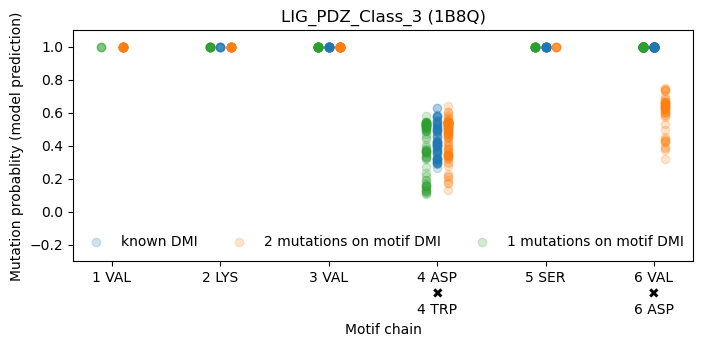

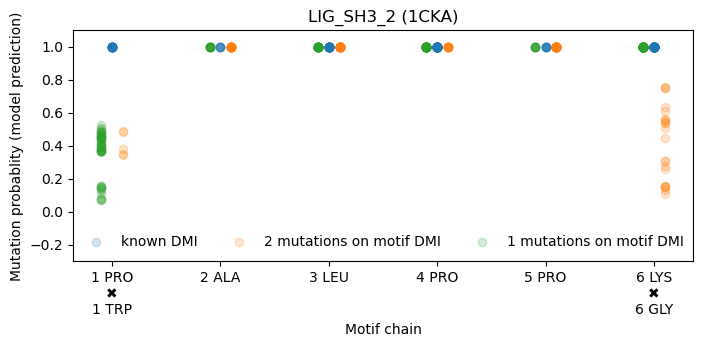

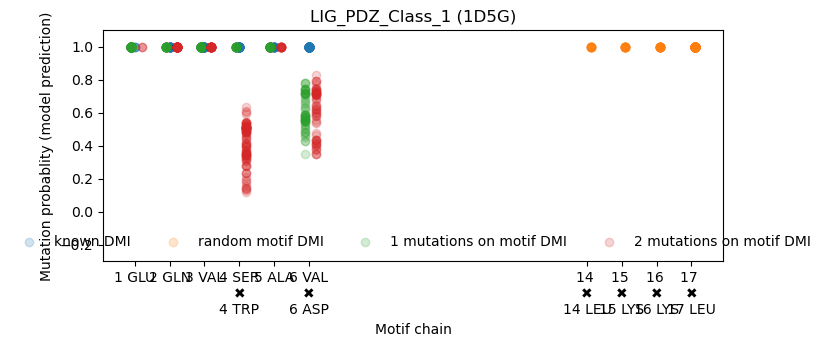

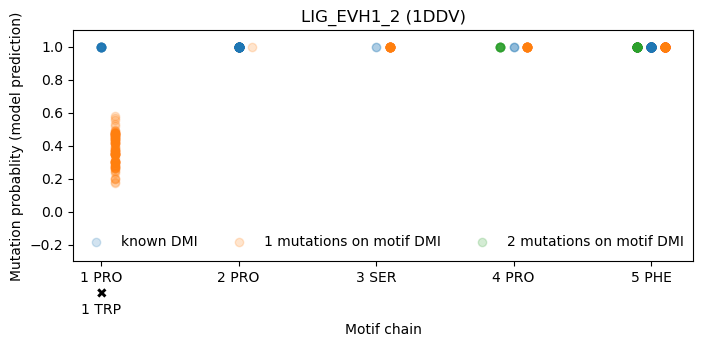

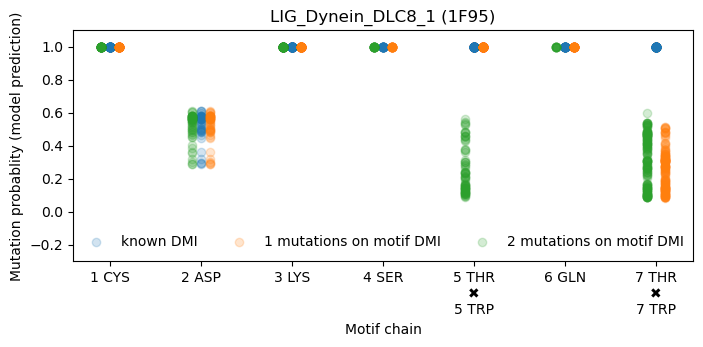

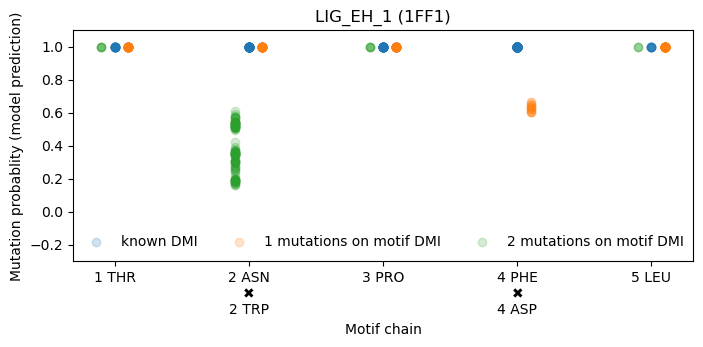

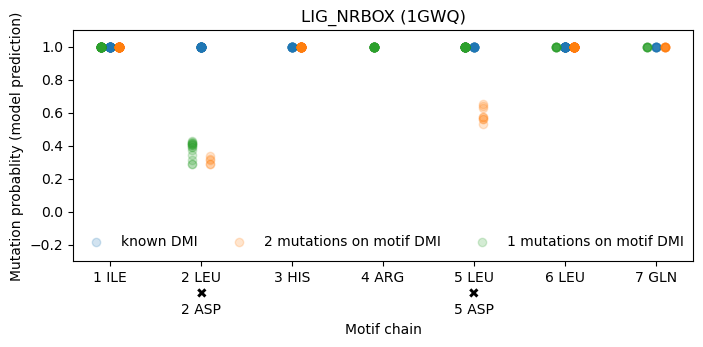

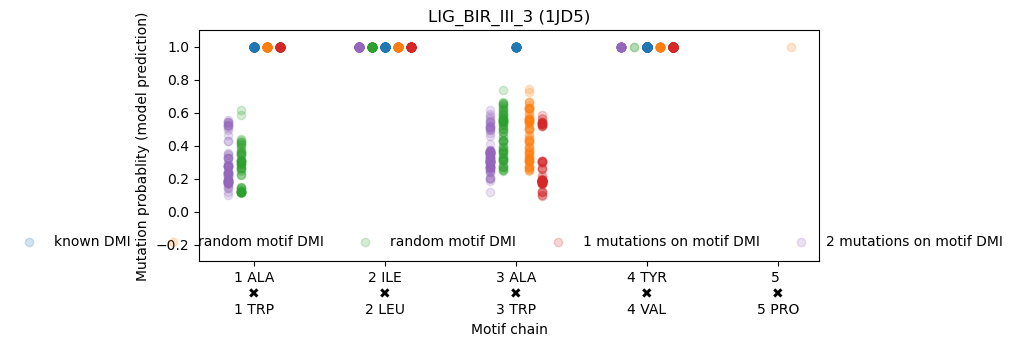

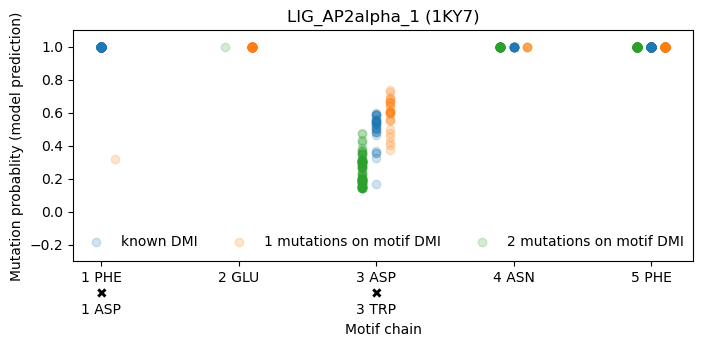

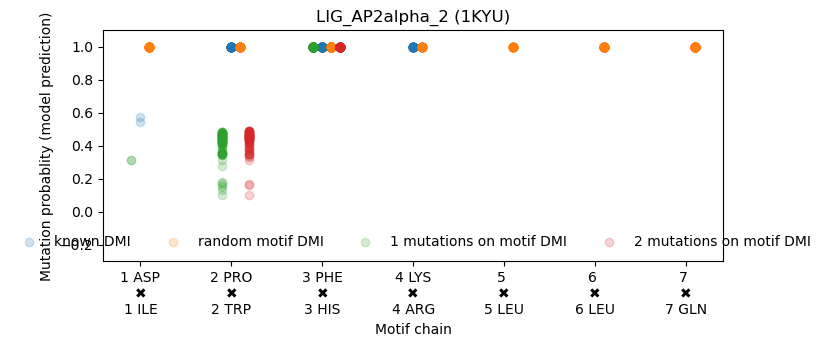

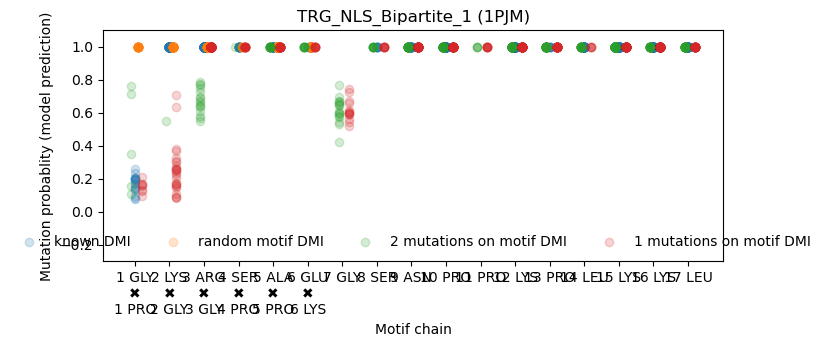

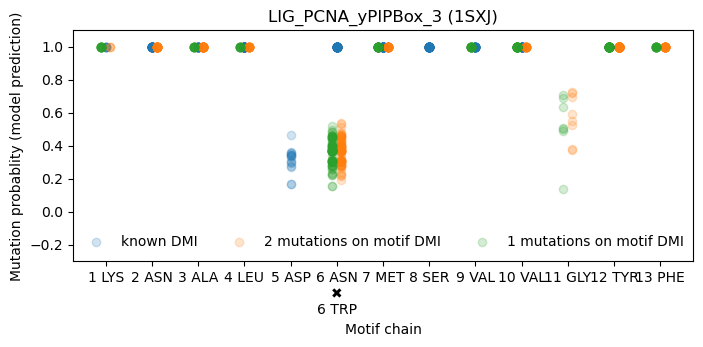

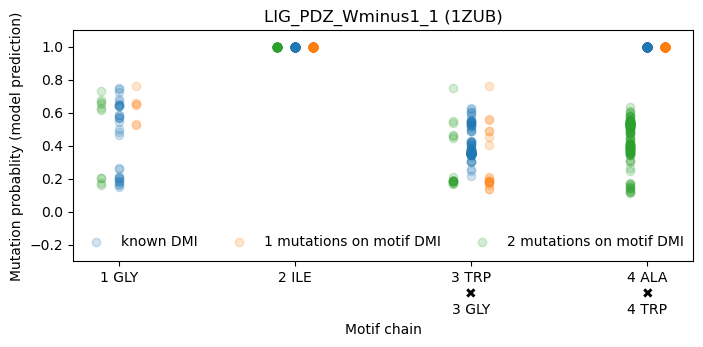

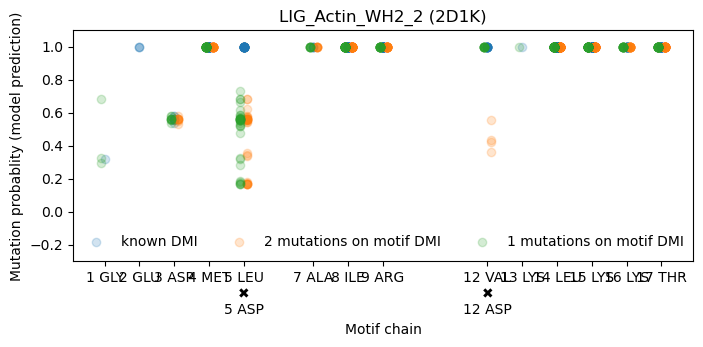

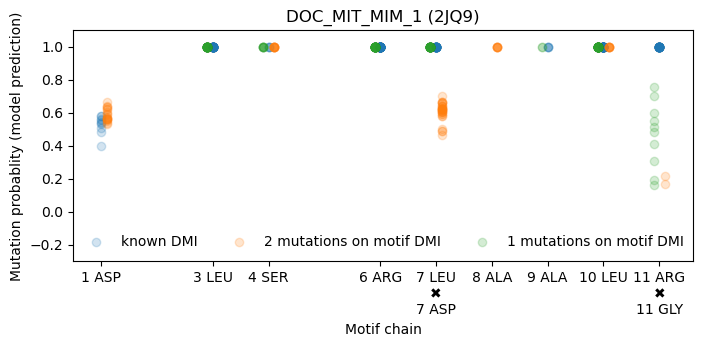

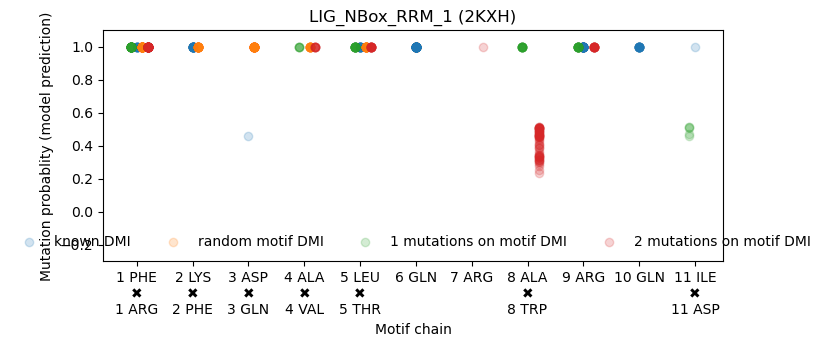

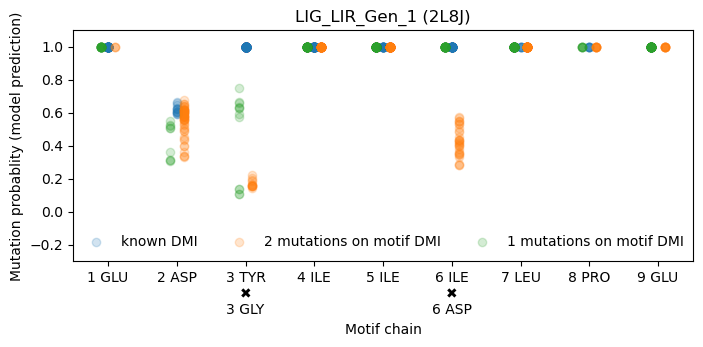

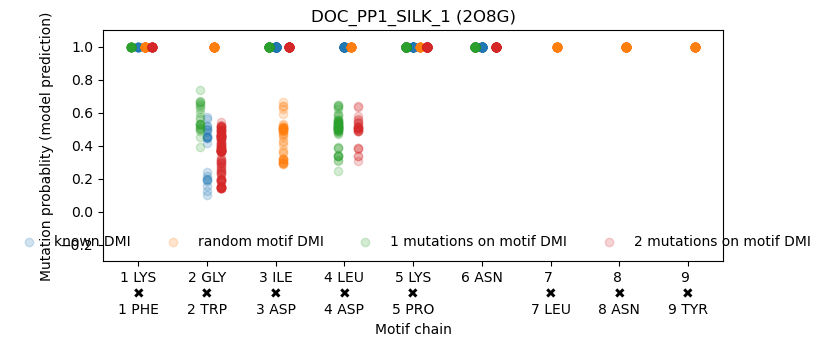

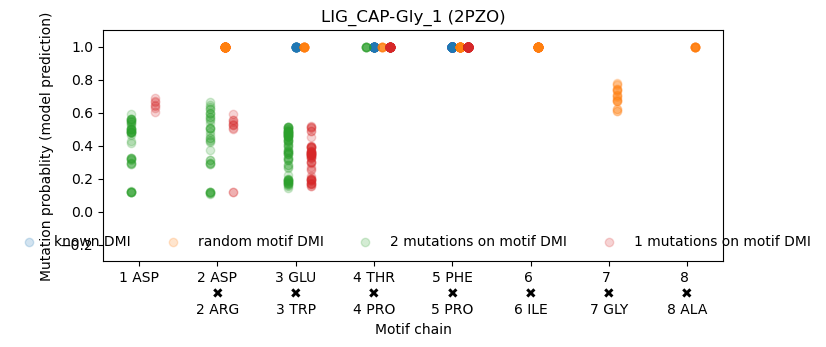

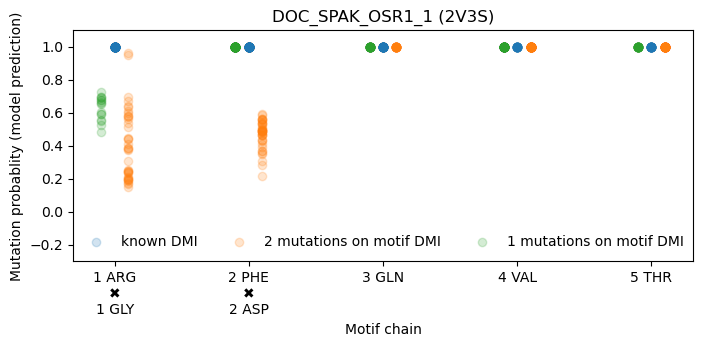

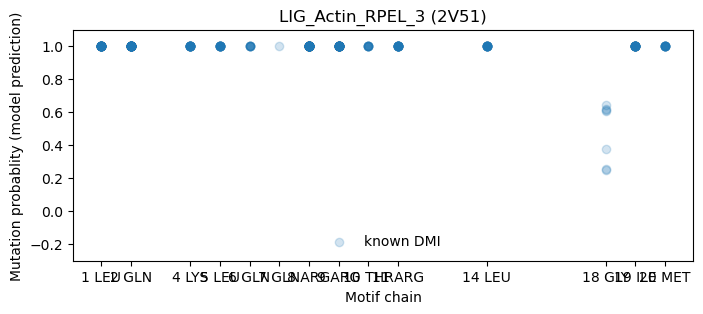

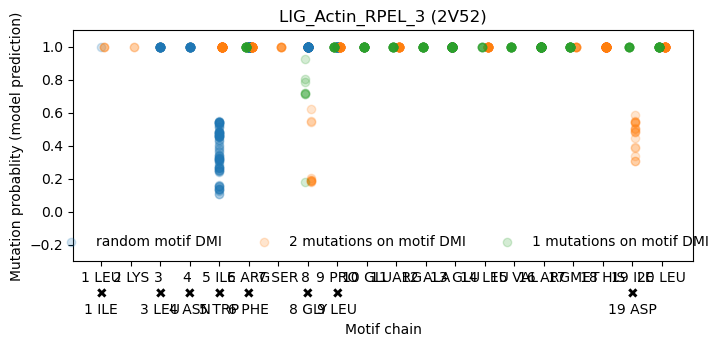

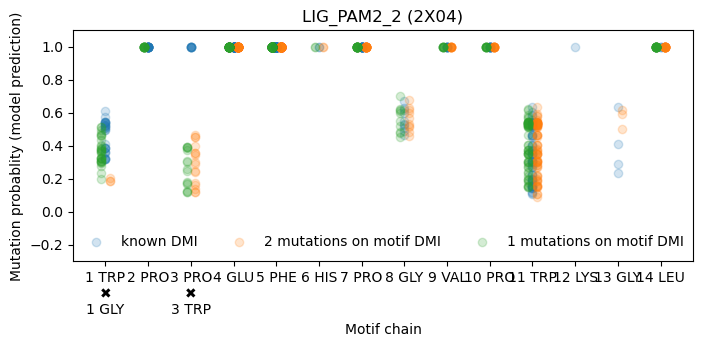

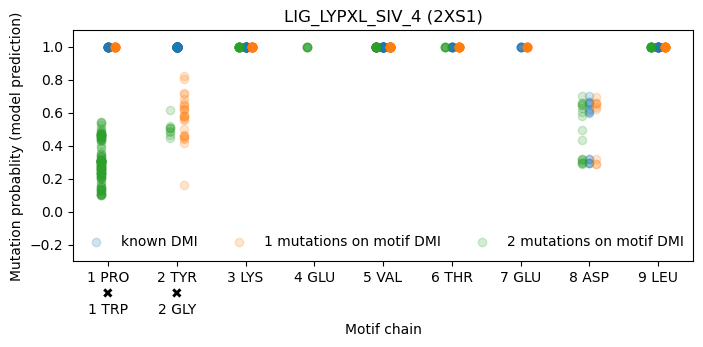

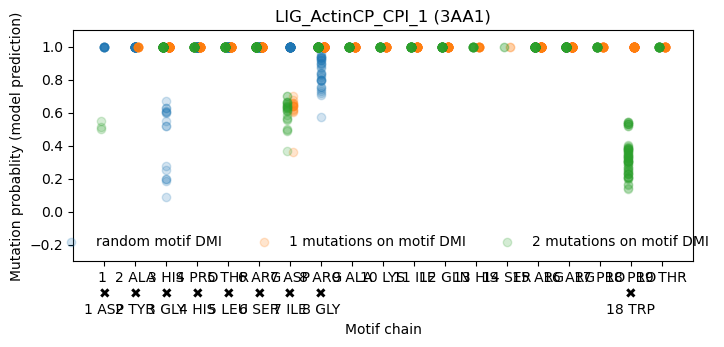

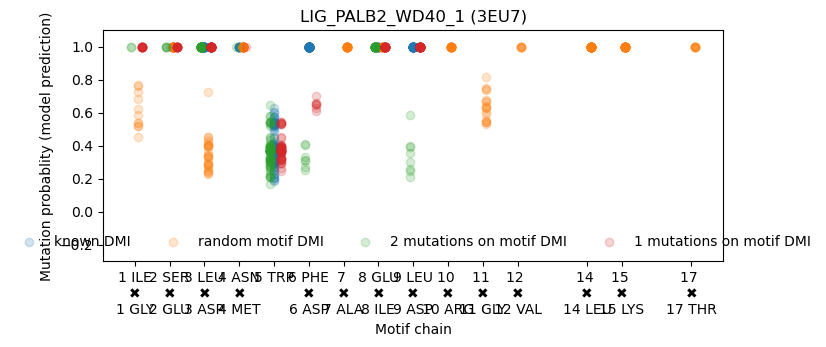

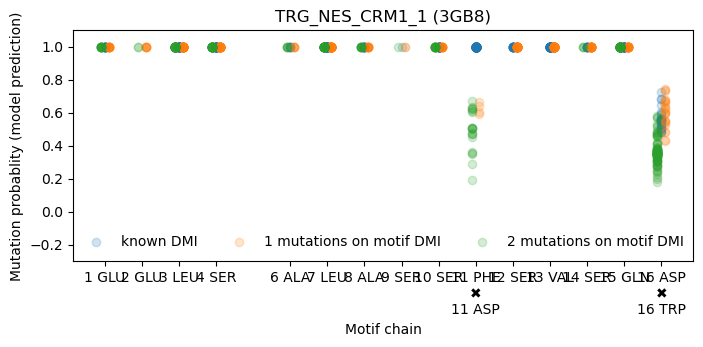

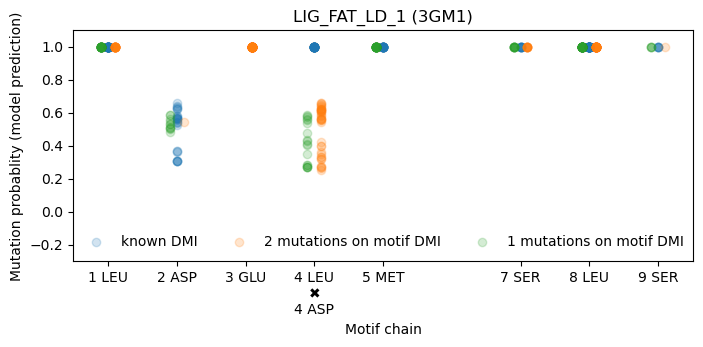

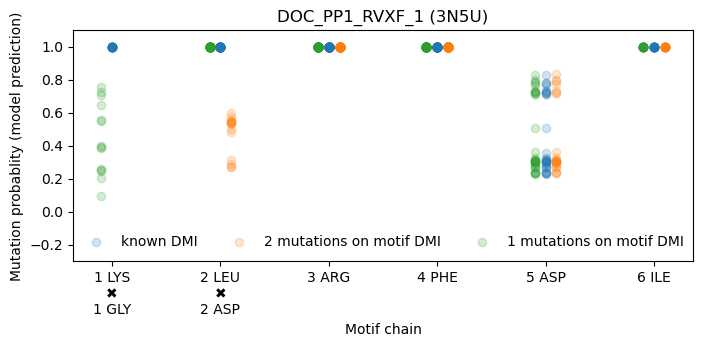

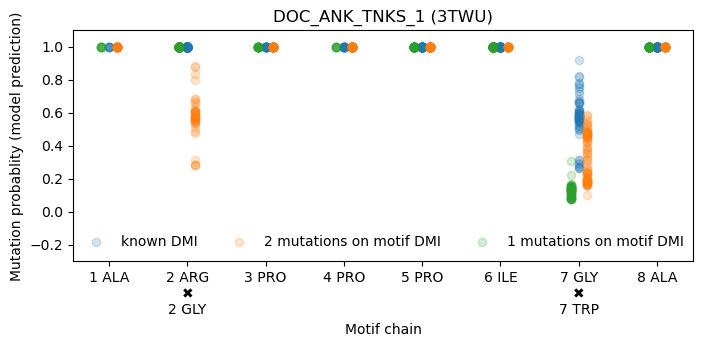

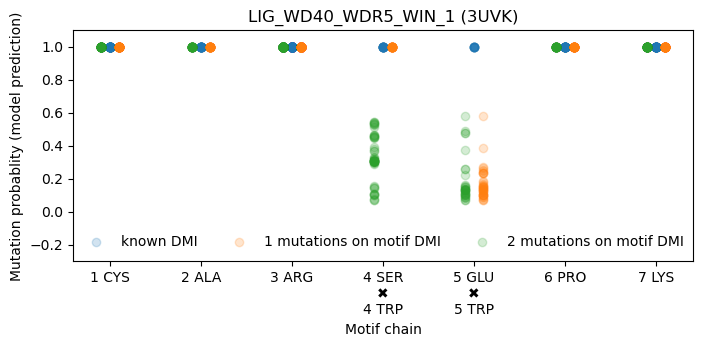

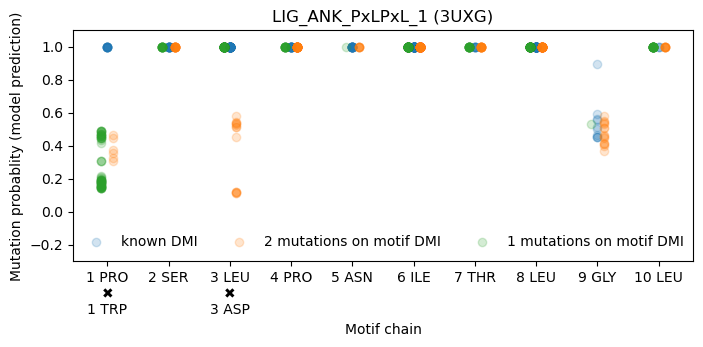

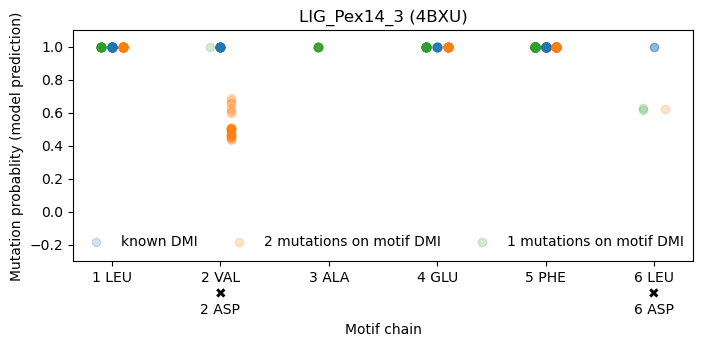

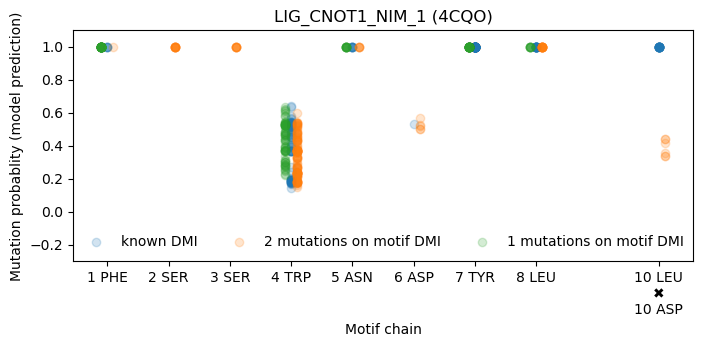

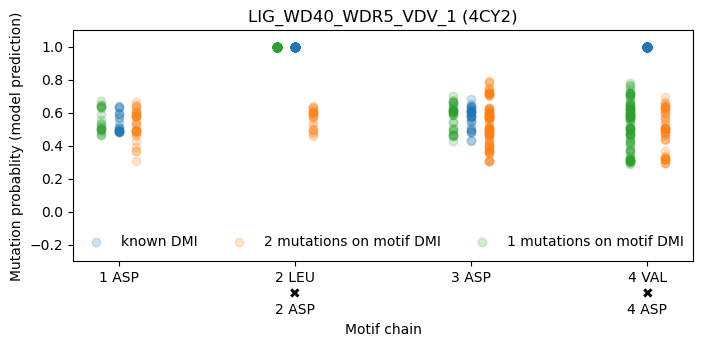

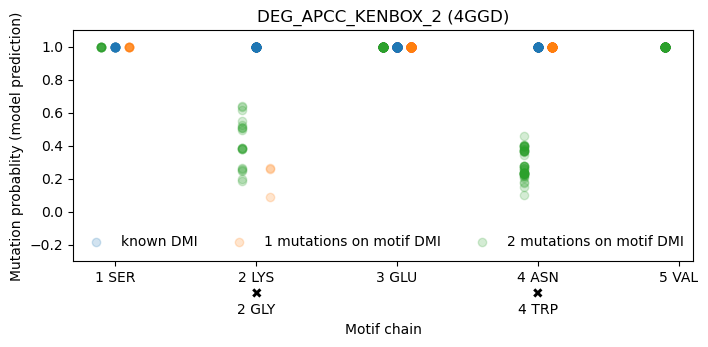

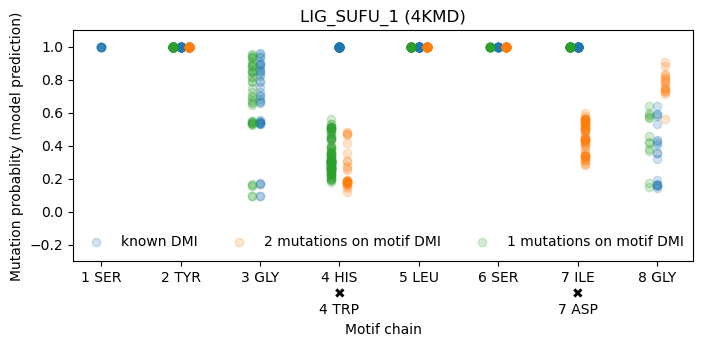

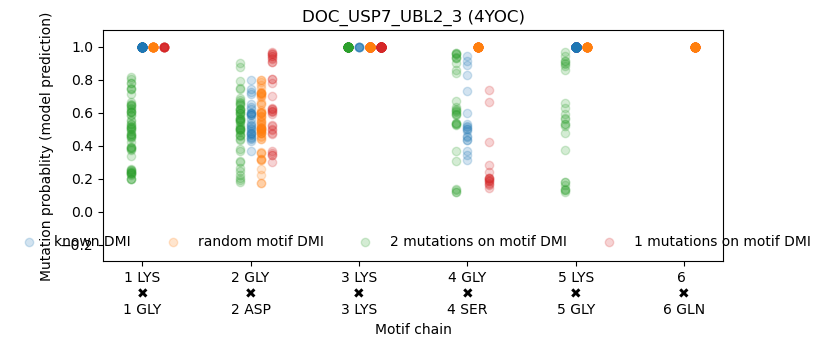

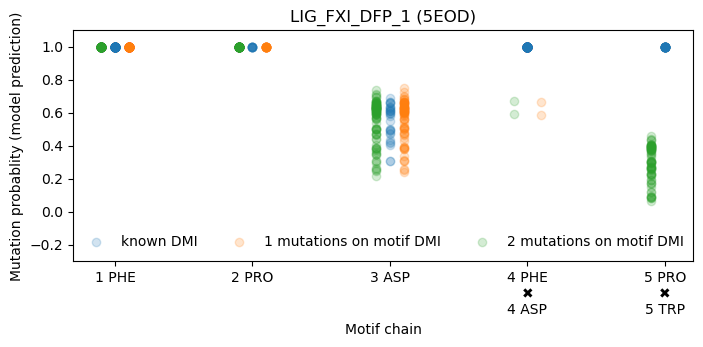

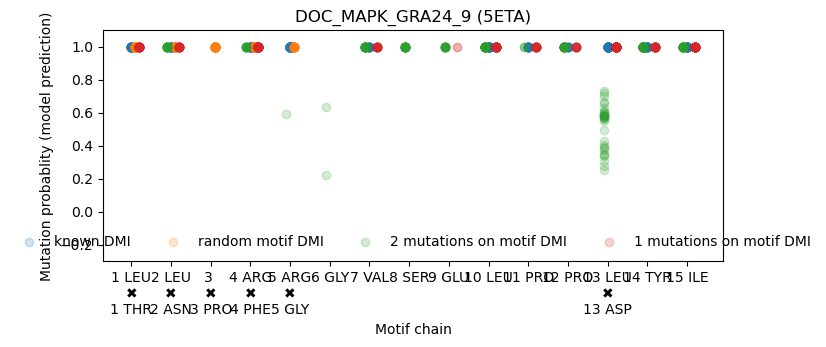

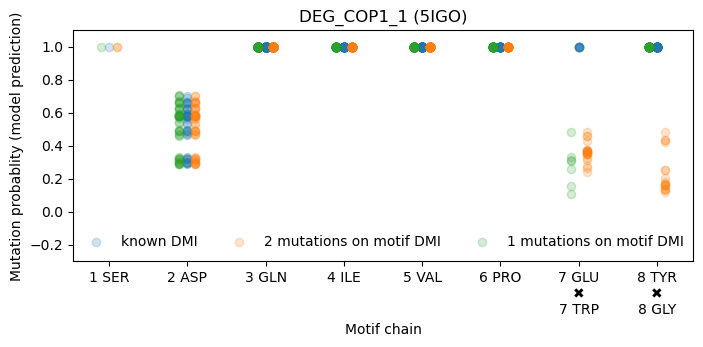

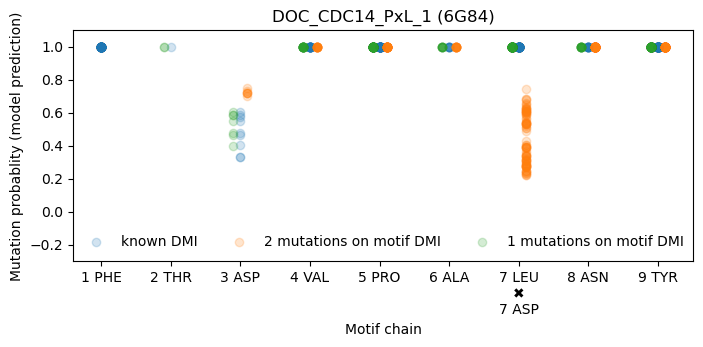

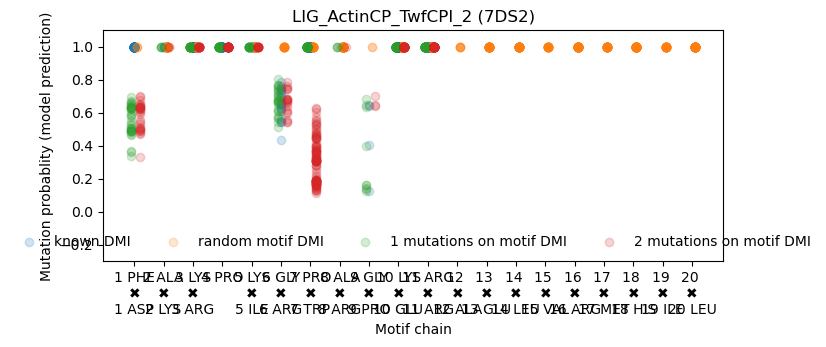

In [153]:
pdb_ids = sorted(list(set(rows_test["PDB_id"])))
for pdb_id in pdb_ids:
    prediction_name, elm_instance = None, None
    intfc_res: list[InterfacePair] = []
    delta_x = 0
    plt.figure(figsize=(8,3))
    for i, row in rows_test[rows_test["PDB_id"] == pdb_id].iterrows():
        prediction_name, elm_instance = row["prediction_name"], row["ELM_instance"]
        benchmark_set = row["benchmark_set"]
        match benchmark_set:
            case "known_DMI":
                label = "known DMI"
            case "random_DMI":
                label ="random motif DMI"
            case "mutations_DMI":
                label = f"{row['num_mutations']} mutations on motif DMI"
            case _:
                label = "?"
        intf = row["interface_AF3"]
        intfc_res.extend(intf.pairs)

        vectors = np.array([interface_pair_to_vector(p) for p in intf.pairs if interface_pair_to_vector(p) is not None])
        vectors_x, vectors_y = vectors[:, 0:(vectors.shape[1]-1)], vectors[:, vectors.shape[1]-1]

        x = [p.atom2.parent.id[1] + delta_x for p in intf.pairs]
        y_proba = clf.predict_proba(vectors_x)

        plt.scatter(x, y_proba[:,1], alpha=0.2, label=f"{label}")
        if delta_x > 0:
            delta_x = -delta_x
        else:
            delta_x = np.abs(delta_x) + 0.1

    res_dict: dict[int, tuple[str, bool]] = {} # tuple: residue name, mutated name
    for p in intfc_res:
        res_id = p.atom2.parent.id[1]
        if res_id not in res_dict.keys():
            res_dict[res_id] = ["", ""]
        if p.valid:
            res_dict[res_id][0] = p.atom2.parent.resname
        else:
            res_dict[res_id][1] = p.atom2.parent.resname
    
    res_dict = dict(sorted(res_dict.items()))
    x_ticks = {res_id: f"{res_id} {resname}" + ("" if resname_mutation == "" else f'\n✖\n{res_id} {resname_mutation}') for res_id, (resname, resname_mutation) in res_dict.items()}

    plt.title(f"{elm_instance} ({pdb_id})")
    plt.xticks(list(x_ticks.keys()), list(x_ticks.values()))
    plt.ylim((-0.3, 1.1))
    plt.xlabel("Motif chain")
    plt.ylabel("Mutation probablity (model prediction)")
    plt.legend(loc="lower center", frameon=False, ncol=6)
    plt.show()